In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/kaggle/input/titanic/train.csv')


test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

# Prepare the test features (X_test), assuming 'Survived' is not in your test.csv
# If 'Name' is a column in your test data and needs to be removed, do so as well


In [2]:
# Display the first few rows of the dataframe
print(df.head())

# Summary statistics for numerical columns
print(df.describe())

# Check for missing values
print(df.isnull().sum())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load the dataset
df = pd.read_csv('/kaggle/input/titanic/train.csv')

# Drop columns that are unlikely to be useful or have too many unique values (e.g., 'Name', 'Ticket', 'Cabin')
df.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1, inplace=True)

# Handling missing values
# For 'Age', replace missing values with the median age.
# For 'Embarked', replace missing values with the mode (most common port of embarkation).
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# Now, separate features and target variable
X = df.drop('Survived', axis=1)
y = df['Survived']

# Defining numerical and categorical columns
numerical_cols = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_cols = ['Pclass', 'Sex', 'Embarked']

# Creating a preprocessing pipeline for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Creating a preprocessing pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combining preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Applying the preprocessing pipeline to the training data
X_train_prepared = preprocessor.fit_transform(X)


In [4]:
# Load the test dataset
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

# Drop the same columns as we did for the training dataset
# Drop the same columns as we did for the training dataset
test_df.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# Handling missing values in the test dataset, following the new recommendations
# Note: Use the training dataframe (df) for calculating median and mode to avoid data leakage
age_median = df['Age'].median()
fare_median = df['Fare'].median()
embarked_mode = df['Embarked'].mode()[0]

test_df['Age'] = test_df['Age'].fillna(age_median)
test_df['Fare'] = test_df['Fare'].fillna(fare_median)
test_df['Embarked'] = test_df['Embarked'].fillna(embarked_mode)

# Applying the preprocessing pipeline to the test data (ensure preprocessor is defined as before)
X_test_prepared = preprocessor.transform(test_df)


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Initialize the model with scaling and increased iterations
full_pipeline_with_predictor = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter=1000)
)

# Fit the complete pipeline to your training data
full_pipeline_with_predictor.fit(X, y) # Use logreg_scaled for predictions




Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [6]:
y_pred = full_pipeline_with_predictor.predict(test_df)

In [7]:
import pandas as pd
from sklearn.metrics import accuracy_score

# Load the true labels
true_labels_df = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

# Assuming test_df is your full test dataset
# Filter the test dataset to only include the PassengerIds present in true_labels_df
filtered_test_df = test_df[test_df['PassengerId'].isin(true_labels_df['PassengerId'])]

# Predict on the filtered test dataset
# Note: Make sure your pipeline is named 'full_pipeline_with_predictor'
y_pred_filtered = full_pipeline_with_predictor.predict(filtered_test_df.drop(['PassengerId'],axis=1))

# Since we filtered the test dataset based on 'gender_submission.csv', the order of predictions should match
# Hence, we can directly compare 'y_pred_filtered' with the 'Survived' column in 'true_labels_df'

predictions_df = pd.DataFrame({
    'PassengerId': filtered_test_df['PassengerId'],
    'Survived': y_pred_filtered
})

# Merge the predictions with the true labels based on 'PassengerId'
merged_results = true_labels_df.merge(predictions_df, on='PassengerId', how='left')

# Calculate accuracy
accuracy = accuracy_score(merged_results['Survived_x'], merged_results['Survived_y'])
print(f"Model Accuracy on Filtered Test Set: {accuracy}")

Model Accuracy on Filtered Test Set: 0.9473684210526315


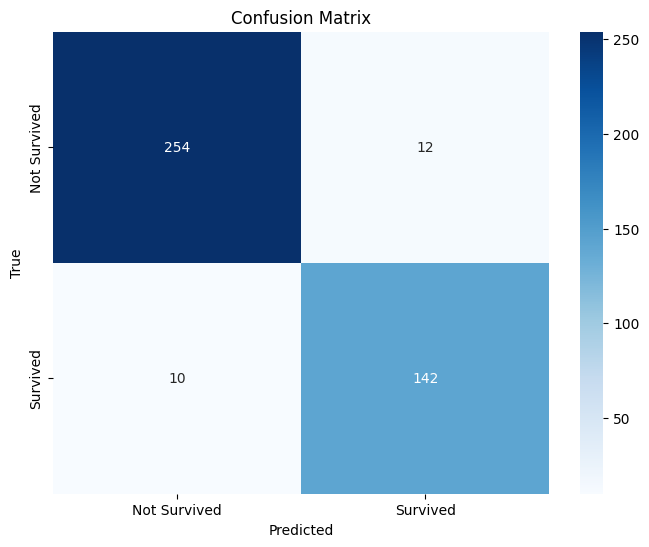

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_true and y_pred are your true labels and predictions
cm = confusion_matrix(merged_results['Survived_x'], merged_results['Survived_y'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


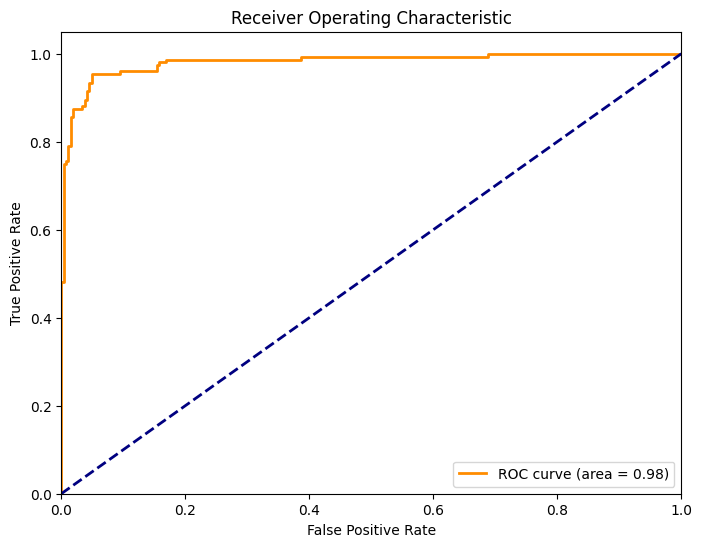

In [9]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC for the model
fpr, tpr, thresholds = roc_curve(merged_results['Survived_x'], full_pipeline_with_predictor.predict_proba(filtered_test_df.drop(['PassengerId'], axis=1))[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


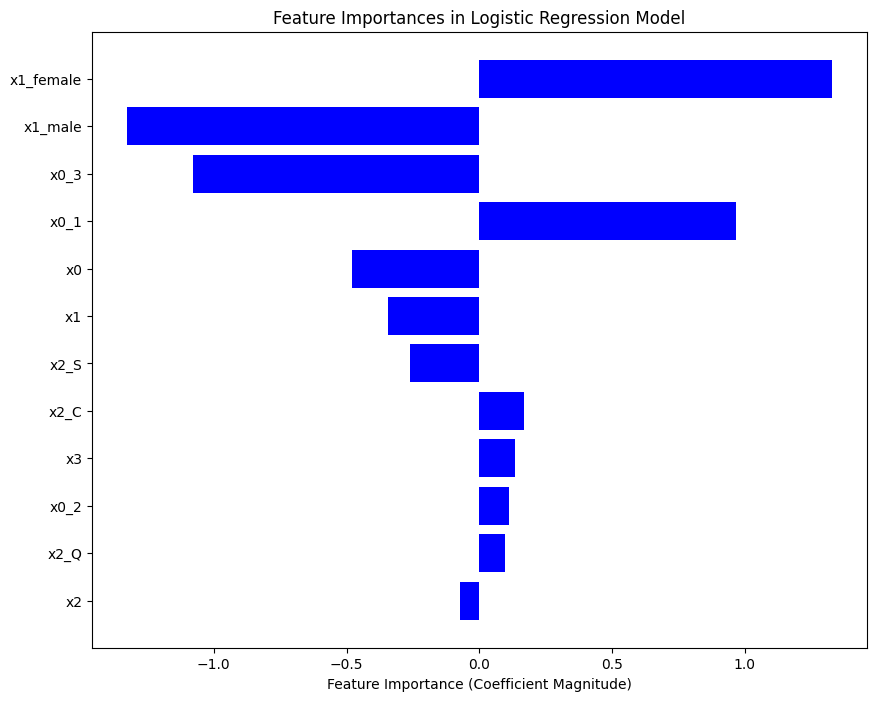

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'full_pipeline_with_predictor' is your pipeline with a logistic regression model at the end
# and 'preprocessor' is your ColumnTransformer preprocessing pipeline

# Step 1: Extract transformed feature names from the ColumnTransformer
# This function helps in extracting feature names from the ColumnTransformer
# Adjust the function to handle different transformers and the 'passthrough' case
def get_feature_names_out(column_transformer):
    """Get feature names from all transformers within a ColumnTransformer."""
    feature_names = []
    
    # Loop through each transformer within the ColumnTransformer
    for transformer_info in column_transformer.transformers_:
        transformer_name, transformer, original_features = transformer_info
        
        # Handle transformers that are dropped
        if transformer == 'drop':
            continue
        elif transformer == 'passthrough':
            # For passthrough, the original column names are used
            feature_names.extend(original_features)
            continue
        
        # Extract feature names for transformers with get_feature_names_out
        if hasattr(transformer, 'get_feature_names_out'):
            # Note: We adjust the condition to properly access get_feature_names_out for transformers
            if hasattr(transformer, 'named_steps'):  # For Pipelines
                # Access the last step of the pipeline
                last_step = transformer.named_steps[next(reversed(transformer.named_steps))]
                if hasattr(last_step, 'get_feature_names_out'):
                    names = last_step.get_feature_names_out()
                    feature_names.extend(names)
                else:
                    feature_names.extend(original_features)
            else:
                names = transformer.get_feature_names_out(original_features)
                feature_names.extend(names)
        else:
            feature_names.extend(original_features)
    
    return feature_names

# Extract feature names considering the corrected function
feature_names = get_feature_names_out(preprocessor)

# Proceed with plotting feature importances
model = full_pipeline_with_predictor.named_steps['logisticregression']
coefficients = model.coef_[0]

# Ensure matching lengths between feature names and coefficients
assert len(feature_names) == len(coefficients), "Mismatch in the number of feature names and coefficients."

# Plotting
indices = np.argsort(np.abs(coefficients))[::-1]
plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), coefficients[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance (Coefficient Magnitude)')
plt.title('Feature Importances in Logistic Regression Model')
plt.gca().invert_yaxis()
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


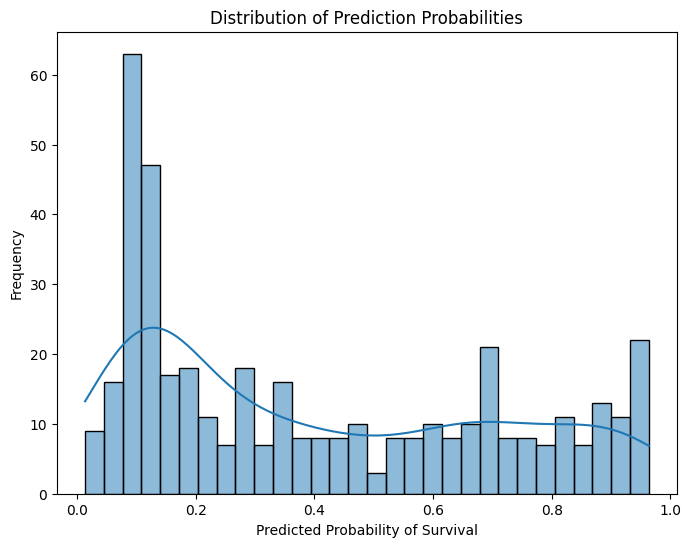

In [11]:
# Assuming you have prediction probabilities
pred_probs = full_pipeline_with_predictor.predict_proba(filtered_test_df.drop(['PassengerId'], axis=1))[:, 1]

plt.figure(figsize=(8, 6))
sns.histplot(pred_probs, kde=True, bins=30)
plt.title('Distribution of Prediction Probabilities')
plt.xlabel('Predicted Probability of Survival')
plt.ylabel('Frequency')
plt.show()
